In [5]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [6]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1
#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1


#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]*result["Ten Hours Non Zero"]*result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['Ten Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > Five Hundred'] == True)
    elif(measure == 3):
        mask = (df3['Three Timeblock'] == True)    
    elif(measure == 4):
        mask = (df3['All Three True'] == True)
    filtered_df = df3.loc[mask].drop(['Ten Hours Non Zero', 'Steps > Five Hundred', 'Three Timeblock', 'All Three True'], axis=1)

    return filtered_df

# Method 1 calculates daily steps based on all the step activity that is available during the day
def all_step_activity(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def top_ten_most_active_hours(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def ten_hour_time_block(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = top_ten_most_active_hours(filtered_df)
    dailysteps_method1 = all_step_activity(filtered_df)
    dailysteps_method3 = ten_hour_time_block(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3

In [7]:
filename = "user2.csv"

filter_measure = 3
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, filter_measure, start_time, end_time)

#### Method 1

In [8]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(1698, 1)

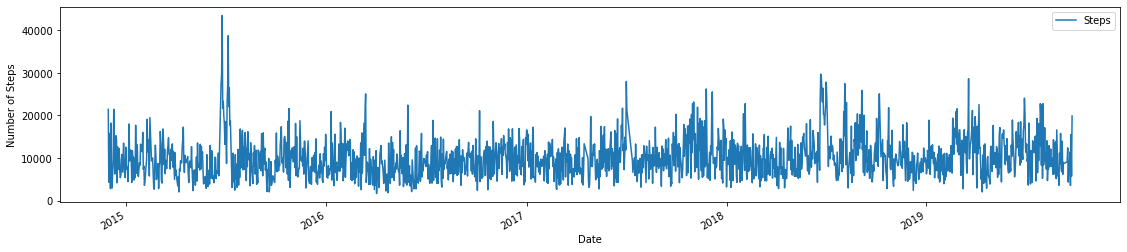

In [9]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

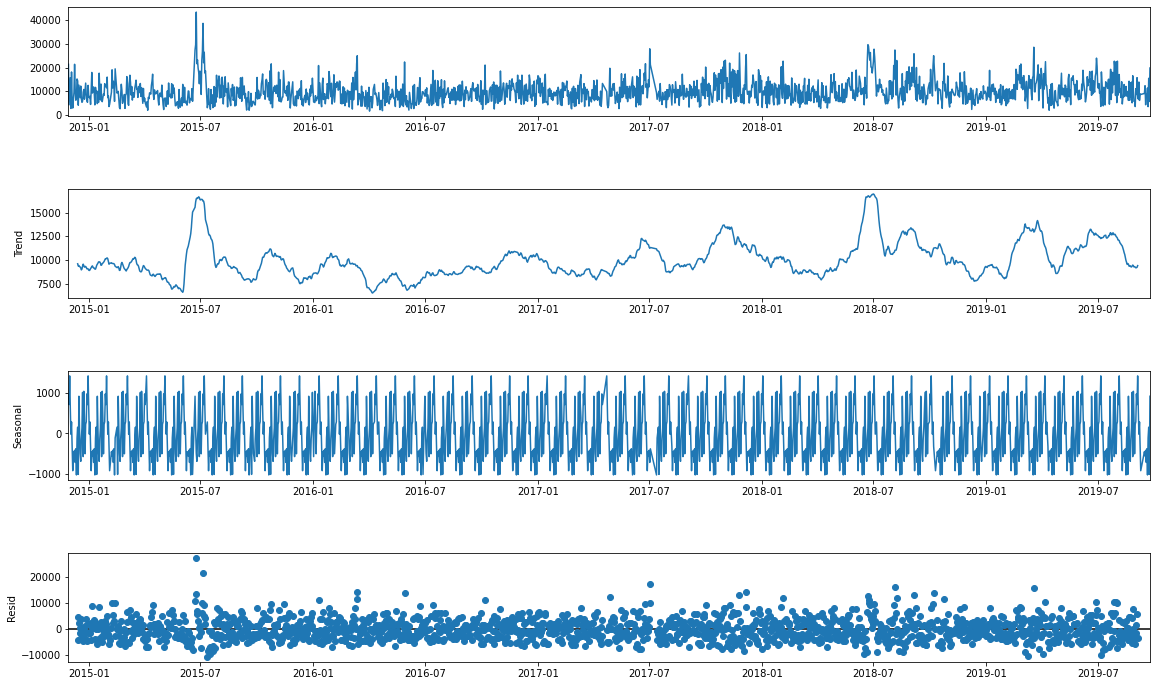

In [10]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', freq = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

The data still has seasonality 

#### Check for data stationary

In [11]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

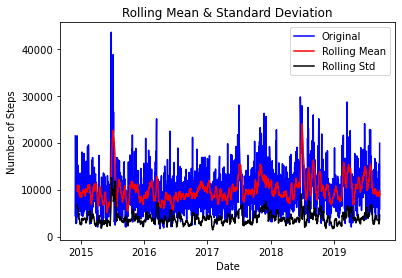

Results of Dickey Fuller Test:
ADF Test Statistic            -8.392514e+00
p-value                        2.345880e-13
#Lags Used                     1.400000e+01
Number of Observations Used    1.683000e+03
Critical Value (1%)           -3.434241e+00
Critical Value (5%)           -2.863259e+00
Critical Value (10%)          -2.567685e+00
dtype: float64


In [12]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 2.345880e-13 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

#### (S)ARIMA Parameters

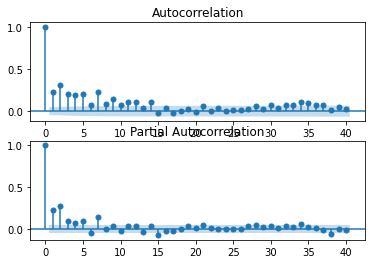

In [13]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0], lags = 40)
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1], lags = 40)
plt.show()

In [14]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=4, max_q=4, m=12,
                            seasonal=True,
                           d=0 , trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=33550.842, BIC=33572.591, Fit time=4.322 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=33568.445, BIC=33579.320, Fit time=0.112 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=33473.526, BIC=33495.275, Fit time=1.936 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=33498.980, BIC=33520.729, Fit time=1.093 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=33480.976, BIC=33497.288, Fit time=0.264 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=33472.441, BIC=33499.627, Fit time=8.449 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=33472.255, BIC=33504.879, Fit time=23.397 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=33552.741, BIC=33579.927, Fit time=14.486 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=33346.077, BIC=33384.137, Fit time=20.012 seconds
Fit ARI

So, the best set of parameters to select is ARIMA(4,0,3)(0,0,0,12). I selected m = 12 to represent the yearly number of months each 'season' runs for.

Optimization terminated successfully.
         Current function value: 9.820433
         Iterations: 5
         Function evaluations: 483


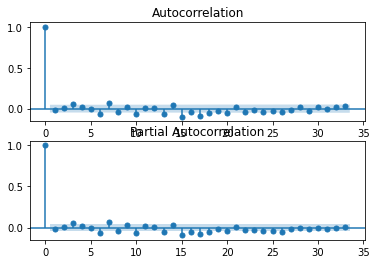

In [15]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(4,0,3), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [25]:
train = ds_method1.loc['2014-11-29':'2018-10-13']
test = ds_method1.loc['2019-09-24':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [26]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(4, 0, 3),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1698
Model:               SARIMAX(4, 0, 3)   Log Likelihood              -16687.391
Date:                Wed, 18 Nov 2020   AIC                          33390.782
Time:                        10:45:37   BIC                          33434.260
Sample:                             0   HQIC                         33406.880
                               - 1698                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2619      0.048     -5.414      0.000      -0.357      -0.167
ar.L2          1.1488      0.022     53.265      0.000       1.107       1.191
ar.L3          0.2905      0.047      6.205      0.0

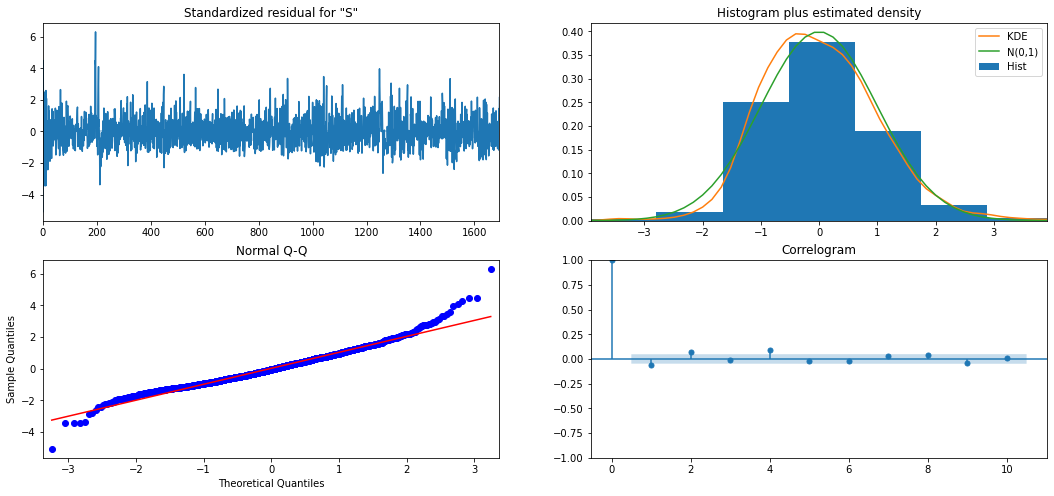

In [27]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [29]:
# the 20% point test data is on the specified date below
split_date = '2018-10-13'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4, 0, 3),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [30]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 22716671.3348
Root Mean Squared Error: 4766.2009
Mean Absolute Error: 3871.8906


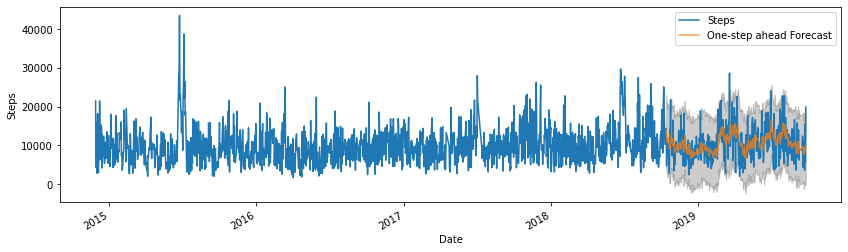

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-13'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 2

In [32]:
ds_method2.set_index('Date',inplace=True)
ds_method2.shape

(1698, 1)

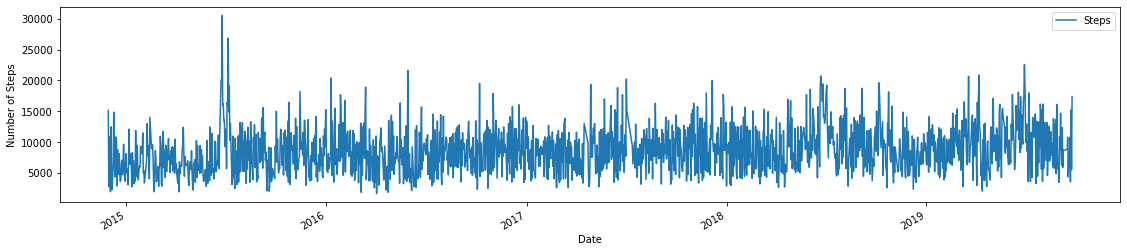

In [33]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

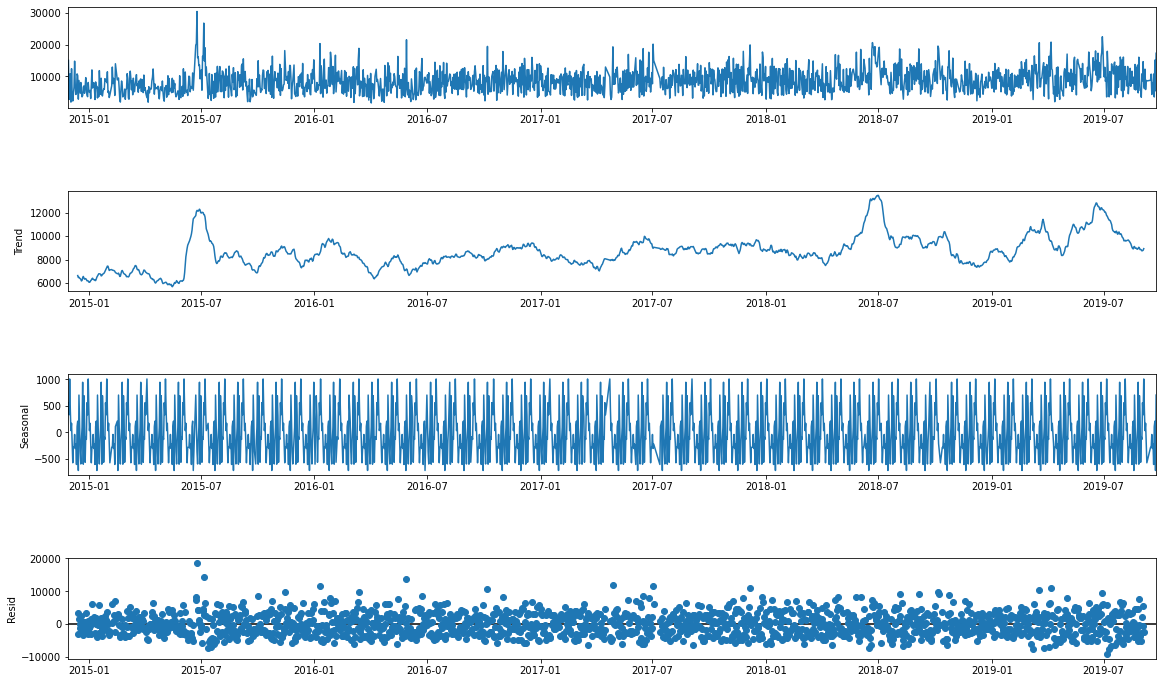

In [34]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, data is seasonable

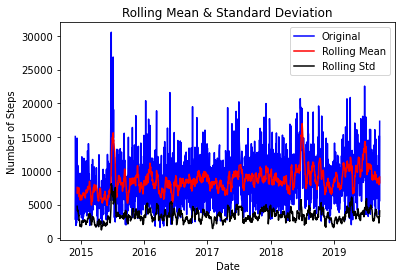

Results of Dickey Fuller Test:
ADF Test Statistic            -7.203012e+00
p-value                        2.338796e-10
#Lags Used                     1.400000e+01
Number of Observations Used    1.683000e+03
Critical Value (1%)           -3.434241e+00
Critical Value (5%)           -2.863259e+00
Critical Value (10%)          -2.567685e+00
dtype: float64


In [35]:
test_stationarity(ds_method2)

Data appears to be stationary

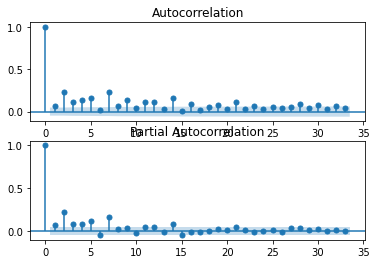

In [36]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [37]:
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=4, max_q=5, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=32765.680, BIC=32787.429, Fit time=1.353 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=32782.764, BIC=32793.638, Fit time=0.048 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=32767.057, BIC=32788.806, Fit time=1.103 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=32761.947, BIC=32783.696, Fit time=0.415 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=32763.825, BIC=32791.011, Fit time=2.089 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=32779.219, BIC=32795.530, Fit time=0.248 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=32763.870, BIC=32791.056, Fit time=1.251 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=32765.745, BIC=32798.368, Fit time=6.747 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=32749.441, BIC=32776.627, Fit time=0.744 seconds
Fit ARIMA:

Best SARIMA is order=(4, 0, 5) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.606458
         Iterations: 4
         Function evaluations: 469


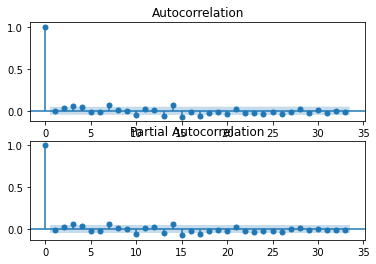

In [38]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(4,0,5), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [39]:
train = ds_method2.loc['2014-11-29':'2018-10-13']
test = ds_method2.loc['2019-09-24':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [40]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(4,0,5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1698
Model:               SARIMAX(4, 0, 5)   Log Likelihood              -16239.711
Date:                Wed, 18 Nov 2020   AIC                          32499.423
Time:                        10:53:05   BIC                          32553.760
Sample:                             0   HQIC                         32519.543
                               - 1698                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2186      0.156     -1.403      0.161      -0.524       0.087
ar.L2          1.1408      0.117      9.769      0.000       0.912       1.370
ar.L3          0.4411      0.140      3.159      0.0

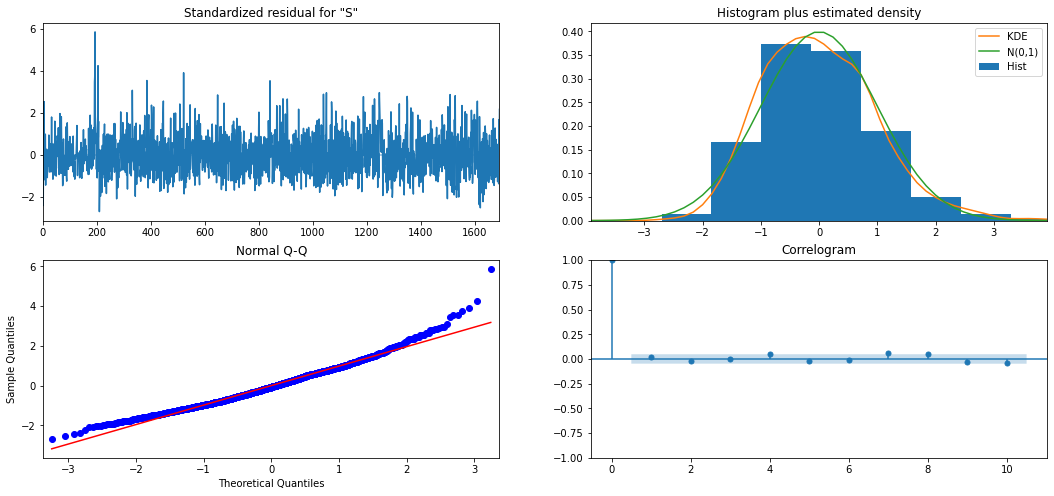

In [41]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [42]:
# the 20% point test data is on the specified date below
split_date = '2018-10-13'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4,0,5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [43]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 15109790.5547
Root Mean Squared Error: 3887.1314
Mean Absolute Error: 3215.8192


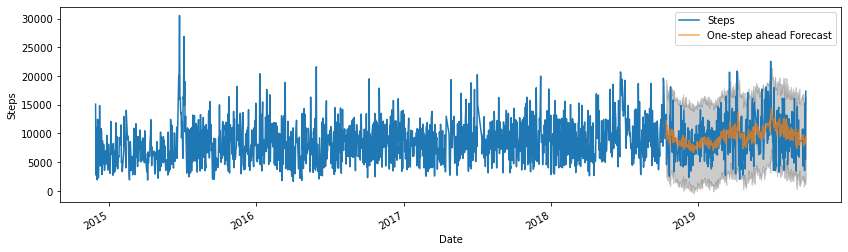

In [44]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-13'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 3

In [45]:
ds_method3.set_index('Date',inplace=True)
ds_method3.shape

(1698, 1)

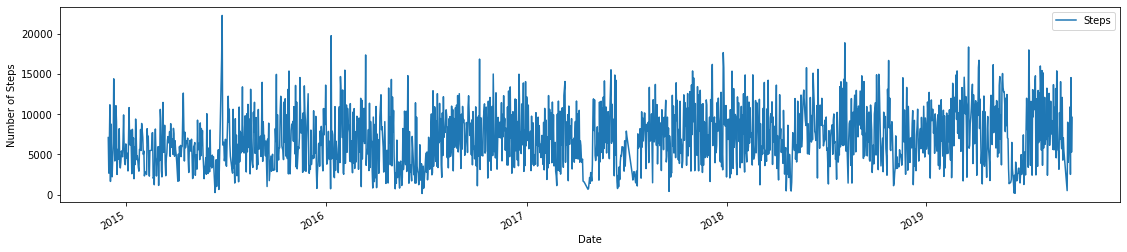

In [46]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

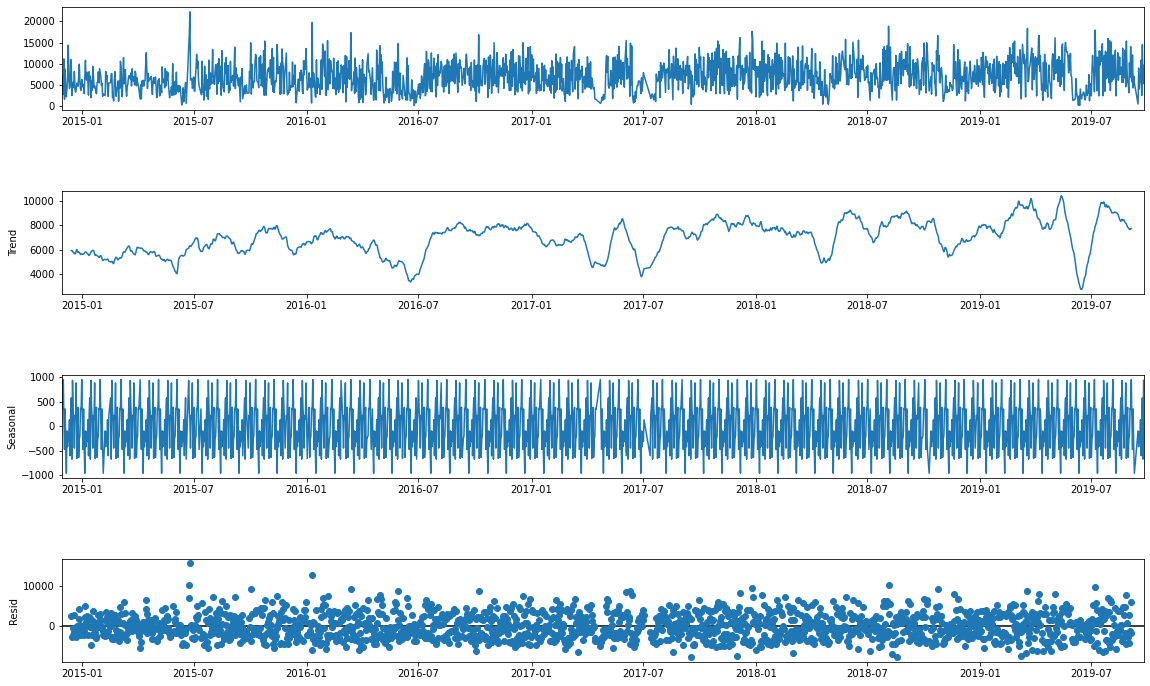

In [48]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, our data is seasonal

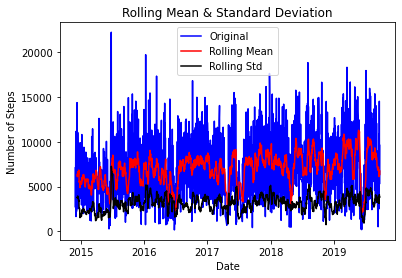

Results of Dickey Fuller Test:
ADF Test Statistic            -7.180348e+00
p-value                        2.659919e-10
#Lags Used                     1.400000e+01
Number of Observations Used    1.683000e+03
Critical Value (1%)           -3.434241e+00
Critical Value (5%)           -2.863259e+00
Critical Value (10%)          -2.567685e+00
dtype: float64


In [49]:
test_stationarity(ds_method3)

P-value is significant, our data is stationary

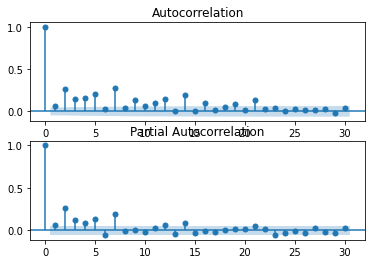

In [50]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3, lags=30, ax=ax[1])
plt.show()

In [51]:
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=4, max_q=5, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=32556.381, BIC=32578.130, Fit time=1.641 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=32587.030, BIC=32597.905, Fit time=0.061 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=32564.168, BIC=32585.917, Fit time=1.428 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=32552.820, BIC=32574.569, Fit time=0.507 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=32554.476, BIC=32581.662, Fit time=2.169 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=32584.272, BIC=32600.584, Fit time=0.295 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=32554.819, BIC=32582.005, Fit time=1.425 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=32556.470, BIC=32589.093, Fit time=7.153 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=32534.131, BIC=32561.318, Fit time=0.823 seconds
Fit ARIMA:

Best ARIMA order=(3, 0, 3) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.541838
         Iterations: 4
         Function evaluations: 348


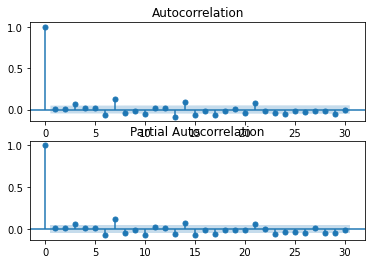

In [52]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(3,0,3), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [53]:
train = ds_method3.loc['2014-11-29':'2018-10-13']
test = ds_method3.loc['2019-09-24':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [54]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(3,0,3),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1698
Model:               SARIMAX(3, 0, 3)   Log Likelihood              -16172.914
Date:                Wed, 18 Nov 2020   AIC                          32359.827
Time:                        10:57:26   BIC                          32397.871
Sample:                             0   HQIC                         32373.914
                               - 1698                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5169      0.103     -5.041      0.000      -0.718      -0.316
ar.L2          0.9737      0.010     98.832      0.000       0.954       0.993
ar.L3          0.5380      0.100      5.386      0.0

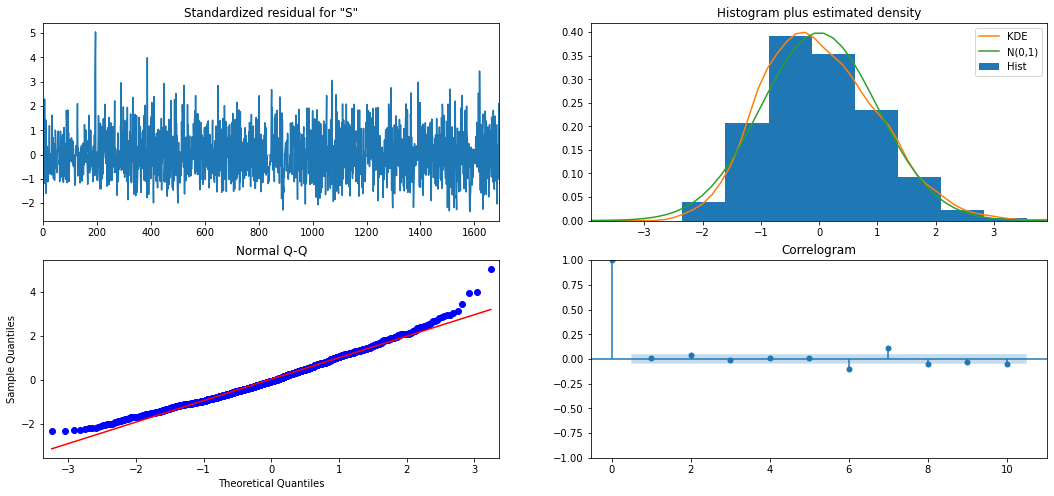

In [55]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [56]:
# the 20% point test data is on the specified date below
split_date = '2018-10-13'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(3,0,3),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [57]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 15975677.675
Root Mean Squared Error: 3996.9586
Mean Absolute Error: 3338.3667


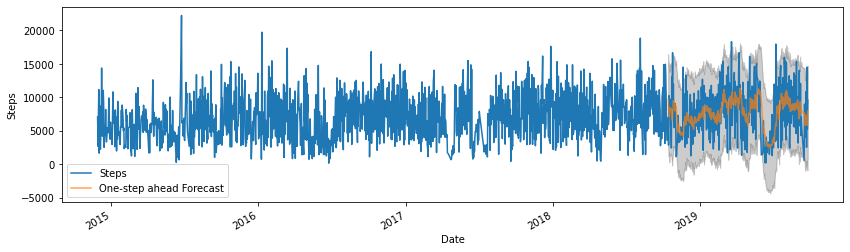

In [58]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-13'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

In [59]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,2.271667e+07,4766.2009,3871.8906
1,Method 2,1.510979e+07,3887.1314,3215.8192
2,Method 3,1.597568e+07,3996.9586,3338.3667


Based on the above predictions, we can observe that **Method 2** and **Method 3** have a very similar prediction with **Method 1** performing the worst. However, the **RMSE** value of **Model 2** is lower, therefore, we can conclude that the **Method 2** performs the best here.